# CSC413 Assignment 2: American Sign Language

**Deadline**: March 9, 2023 by 6pm

**Submission**: Compile and submit a PDF report containing your code, outputs,
and your written solutions. Do not use screenshots and images to present
textual code/output (other than legible, hand-written answer).
You may export the completed notebook on Google Colab, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

**Working with a partner**: You may work with a partner for this assignment.
If you decide to work with a partner, please create your group on Markus by
the deadline, even if you intend to use grace tokens. Markus does not allow
you to create groups past the deadline, even if you have grace tokens remaining.

[American Sign Language (ASL)](https://en.wikipedia.org/wiki/American_Sign_Language)
is a complete, complex language that employs signs made by 
moving the hands combined with facial expressions and postures of the body. 
It is the primary language of many North Americans who are deaf and is one of several 
communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below.

In this assignment, we will 
classify a subset of these hand gesture images using convolutional neural networks.
Specifically, given an image of a hand showing one of the letters A-I, we want to detect
which letter is being represented.

We will explore several convolutional architectures.
While we will give you a tiny
big of starter code to help make data processing a bit easier,
you'll have a chance to build your neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets

%matplotlib inline

## Question 1. Data

If you are using your own machine, download the data from the course website on Quercus.

If you are using Google Colab, download the data set to your Google Drive by going to
the link [https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing](https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing)
and selecting "Add to My Drive".
This is faster than downloading the data from the course website.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

In [ ]:
train_path = "/content/gdrive/My Drive/A2/asl_data/train/" # edit me
valid_path = "/content/gdrive/My Drive/A2/asl_data/valid/" # edit me
test_path = "/content/gdrive/My Drive/A2/asl_data/test/"   # edit me

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

### Part (a) -- 2 pts

Read up on what `torchvision.datasets.ImageFolder` does for us here
[https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder)

We can iterate through the one training data point at a time like this:

In [ ]:
for x, y in train_data:
    print(x.shape)
    print(y)
    break # uncomment if you'd like

torch.Size([3, 224, 224])
0


What do the variables `x` and `y` contain? What is the shape of our images?
What are our labels? How did PyTorch generate these labels from the folder structure?

Before answering this question, you will need to look at the folder structure
and look at some images in the data set.

# Answer Question 1 Part (a)

The variable x contains the tensor representation of a singular image from the folders (A, B, C, D, E, F, G, H, I) of the main train folder while y is a numeric value representing the image's label. The numeric value of the image's label directly connected with the order of the subfolders. (A:0, B:1, C:2, D:3, E:4, F:5, G:6, H:7, I:8) 

### Part (b) -- 2 pts

We saw in the earlier tutorials that PyTorch has a utility to help us
create minibatches with our data. We can use the same DataLoader helper
here:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y)
    break # uncomment if you'd like

torch.Size([10, 3, 224, 224])
tensor([5, 0, 3, 0, 0, 0, 0, 6, 8, 7])


What do the variables `x` and `y` contain? What are their shapes?
What data do they contain?

# Answer Question 1 Part (b)

The variable x contains 1 mini-batch of 10 images while y contains the 10 target values for each corresponding image in the mini-batch.

x has a shape of 10x3x244x244.

y has a shape of 10.

### Part (c) -- 1 pts

How many images are there in the training, validation, and test sets?

In [ ]:
print("There are", len(train_data), "images in the training data set.")
print("There are", len(valid_data), "images in the validation data set.")
print("There are", len(test_data), "images in the test data set.")

There are 733 images in the training data set.
There are 207 images in the validation data set.
There are 223 images in the test data set.


### Part (d) -- 3 pts

This dataset was generated by students in past machine learning courses, where
each student took several photos of themselves demonstrating the ASL hand gestures.
The file names of the images follow the following convention:
`<student-identifier>_<letter>_<img-count>.jpg`

When we split the data into training, validation, and test sets, we took care
to put photos taken by the same person in the same data set. In other words, if one of the
student's photo is in the training set, then other photos taken by the same student
will also be placed in the training set.

This way of separating the dataset into training, validation and test is more nuanced
than simply randomly splitting the photos into training/validation/test.

Explain why it is important to make sure that we split the photos into the
three datasets **by student**, so that photos from the same student are always in the
same set.

# Answer Question 1 Part (d)

There are multiple reasons to ensure that the datasets by the same student result in the same training, validation, or test data.

One of the reasons is because we want to ensure that the model is not learning the background. If a student's images for a letter are present in multiple datasets, then the model may learn to identify the letter based on the properties of the image (i.e. background, lighting, skin color, etc.) rather than the hand gesture itself. The model would then confirm this training from one dataset using the other(s) and thus incorrectly identify letters based on photo properties. By ensuring the same photo properties do not occur in the same letter for multiple datasets we can ensure that the model must be learning to identify the letter based on the hand gesture, rather than by the properties of the image.

To prevent this from happening we ensure that the model never sees a users' photo properties for a specific letter in multiple datasets. Hence testing on a completely new enviroment will ensure that our accuracy for the test data will be a valid representation of our models ability to classify the character.

## Question 2. Model Building

#### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts
the letter. Your model should be a subclass of `nn.Module`. 
You may want to review the Colab notebook demo from week 6 lectures. There is a small convolutional
neural network included in the notebook.

Here are some rules of thumb when determining your convolutional neural network architecture:

- Nowadays, people prefer small kernel sizes (e.g. 3x3 or 5x5), with many convolutional layers
  (we suggest 3-4 to start).
- Use a downsampling operation after (or with) each convolution layer
- In a typical convolutional neural network architectures, every time we downsample, we double the
  number of features (channels). This is so that we don't lose too much information in each layer.
  You may wish to make the number of output channels in your first convolutional layer a variable,
  and double this value in every subsequent convolutions.
- Typical CNNS will have a few (1-3) fully-connected layers as the final layers.

Explain your choice of neural network architecture: how many layers did you choose?
What types of layers did you use? Were they fully-connected or convolutional? What about other
decisions like pooling layers, activation functions, number of channels / hidden units.

Do not use dropout or batch normalization in this architecture.

# Answer Question 2 Part (a)

We chose our network to contain 3 convolutional layers, 3 pooling layers, and 1 fully connected layer. The activation function that we used was ReLU. The first convolutional layer has input channels = 'input_channels', output channels = '2 x input_channels'. The second convolutional layer has input channels = '2 x input_channels', output channels = '4 x input_channels'. The third convolutional layer has input channels = '4 x input_channels', output channels = '8 x input_channels'. 

Sample Input Process Through This Model: 

Initial Image Size: 3x224x224

After conv1: 6x224x224

After pooling: 6x112x112

After conv2: 12x112x112

After pooling: 12x56x56

After conv3: 24x56x56

After pooling: 24x28x28

After fc: 9

In [ ]:
# Your code goes here
class CNN(nn.Module):
    def __init__(self, input_channels):
        super(CNN, self).__init__()
        self.input_channels = input_channels
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=2*input_channels,
                               kernel_size=3,
                               padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=2*input_channels,
                               out_channels=4*input_channels,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=4*input_channels,
                               out_channels=8*input_channels,
                               kernel_size=3,
                               padding=1)
        self.fc = nn.Linear(8*input_channels * 28 * 28, 9)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 8*self.input_channels * 28 * 28)
        return self.fc(x)


#### Part (b) Convolutional Network with Batch Normalization - 3 pt

Build a variation of your convolutional neural network from part (a), and 
add either at least one batch normalization *or* at least one dropout layer,
but **not** both.
You will need to read the PyTorch documentation to figure out how these layers
function.

In [ ]:
# Your code goes here
class CNN_BATCH(nn.Module):
    def __init__(self, input_channels):
        super(CNN_BATCH, self).__init__()
        self.input_channels = input_channels
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=2*input_channels,
                               kernel_size=3,
                               padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=2*input_channels,
                               out_channels=4*input_channels,
                               kernel_size=3,
                               padding=1)
        self.batch = nn.BatchNorm2d(4*input_channels)
        self.conv3 = nn.Conv2d(in_channels=4*input_channels,
                               out_channels=8*input_channels,
                               kernel_size=3,
                               padding=1)
        self.fc = nn.Linear(8*input_channels * 28 * 28, 9)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.batch(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 8*self.input_channels * 28 * 28)
        return self.fc(x)

#### Part (c) Architecture Decision - 1 pt

It does not make sense to add the batch normalization or dropout layer as
your *final* layer. Explain why this is the case.

# Answer Question 2 Part (c)

It does not make sense to use batch normalization or dropout layer as your final layer since the purpose of these layers would be nullified. 

Batch normalization by definition is recentering and rescaling of a certain layer. If this was done at the final layer there would be no change as the ranges would still be the same. If this was done in the middle then the next layer could potentially learn differently given that the weights would not be skewed.

Dropout layer by definition is a mask that nullifies the contribution of some neurons towards the next layer. Nullifying certain neurons in the final layer will not aid the learning process of the future layers since it is already in the final layer. Nullifying certain neurons in the middle layers will help the future layers to focus on some other neurons to learn from them instead.

## Question 3. Training Code and Sanity Checking

#### Part (a) Accuracy - 3 pt

Compute the `get_accuracy` function, which computes the model accuracy across a dataset:

In [ ]:
def get_accuracy(model, data):
    # note: why should we use a larger batch size here?
    # We should use a larger batch size because it is more efficient 
    # as there will be fewer iterations of the loop.
    loader = torch.utils.data.DataLoader(data, batch_size=256)

    model.eval() # annotate model for evaluation (why do we need to do this?)

    correct = 0
    total = 0
    for imgs, labels in loader:
        output = model(imgs) 
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += imgs.shape[0]

    return correct / total

#### Part (b) Training Code - 8 pt

Write code to train your neural network given some training data. Your training code
should make it easy to tweak hyperparameters. Make sure that you are checkpointing
your models from time to time (the frequency is up to you). 

Here's what we will be looking for:

- using the data loader to load the training data
- using the correct choice of loss function and a reasonable optimizer
- shuffling the training data at the start of each epoch
- in each iteration, take `batch_size` samples from the data set
- use the correct labels from the data set
- computing the forward and backward passes
- after every epoch, **checkpoint your model** (A1 had instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and **plot the training curve**
- correctly handling edge cases (e.g. why might the last batch be smaller than the rest?)

Don't forget the checkpointing step. You will need to load your model weights later.

In [ ]:
# Your code goes here

# You can use this function header, but don't have to:
def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0,
           learning_rate=0.001, num_epochs=7, checkpoint_name="cnn"):
    
    import os
    if not os.path.exists('/content/gdrive/My Drive/A2/'+checkpoint_name):
        os.makedirs('/content/gdrive/My Drive/A2/'+checkpoint_name)
    checkpoint_path = '/content/gdrive/My Drive/A2/'+checkpoint_name+'/ckpt-{}.pk'
    
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)
    
    iters, losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):

        train_loader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)

        for imgs, labels in iter(train_loader):
            if imgs.size()[0] < batch_size:
                continue

            model.train() # annotate model for training
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_data)) # compute training accuracy 
        val_acc.append(get_accuracy(model, valid_data))  # compute validation accuracy

        torch.save(model.state_dict(), checkpoint_path.format(epoch))

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

#### Part (c) Overfit to a Small Dataset - 2 pt

One way to sanity check our neural network model and training code is to check whether 
each of your two models is capable of "memorizing" or "overfitting" to a small dataset. Construct
a small dataset (e.g. 1-2 image per class). Then show that your model and training code
is capable of overfitting on that small dataset. You should be able to obtain a 100% 
training accuracy on that small dataset relatively quickly (i.e. within a few hundred iterations,
possibly more depending on your learning rate).

This question is really here to make sure that your model/training code is correct.
The question itself is not worth much, but your results here will diagnose issues
from other parts of your code.
If your models cannot overfit the small dataset quickly, then there is
a bug in either your model code and/or your training code. Fix the issues
before you proceed to the next step.

In [ ]:
lst = []
unq = [2]*9

index = 0

for _, y in train_data:
    if unq[y] > 0:
        lst.append(index)
        unq[y] -= 1
    
    index += 1

lst = np.array(lst)
small_dataset = torch.utils.data.Subset(train_data, lst)

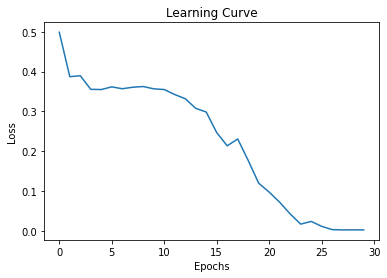

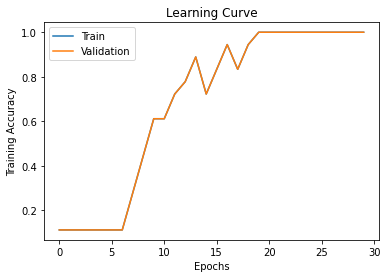

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


1.0

In [ ]:
model = CNN(3)

train(model, 
      small_dataset, 
      small_dataset, 
      batch_size=6, 
      num_epochs=30, 
      checkpoint_name="cnnSmall")

get_accuracy(model, small_dataset)

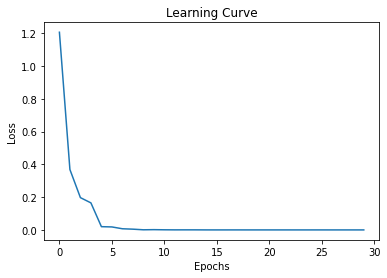

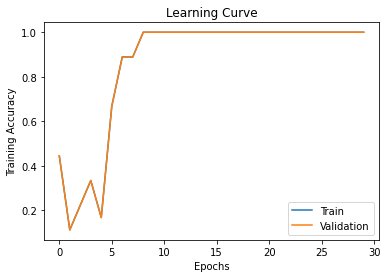

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


1.0

In [ ]:
model = CNN_BATCH(3)

train(model, 
      small_dataset, 
      small_dataset, 
      batch_size=6, 
      num_epochs=30, 
      checkpoint_name="cnnSmallBatch")

get_accuracy(model, small_dataset)

## Question 4. Training

### Part (a) -- 5 points

Train your first network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!

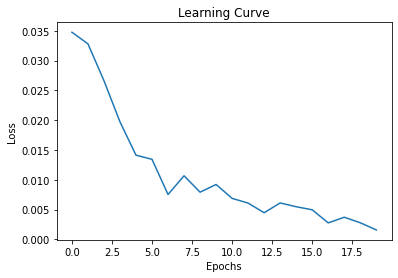

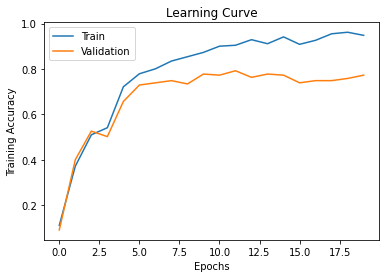

Final Training Accuracy: 0.9481582537517054
Final Validation Accuracy: 0.7729468599033816
Final Test Accuracy 0.6771300448430493


In [ ]:
model = CNN(3)

train(model, 
      train_data, 
      valid_data,
      batch_size=64, 
      num_epochs=20, 
      checkpoint_name="cnn")

print("Final Test Accuracy", get_accuracy(model, test_data))

### Part (b) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (a).
In this section, briefly explain the hyperparamter choices that you tried, 
and how they impacted your training.

# Answer: Question 4 Part (b)

<table>
<tr>
<th>Trials</th>
<th>Batch Size</th>
<th>Epochs</th>
<th>Training Accuracy</th>
<th>Validation Accuracy</th>
<th>Testing Accuracy</th>
</tr>
<tr>
<th>1</th>
<th>32</th>
<th>7</th>
<th>89</th>
<th>75</th>
<th>65</th>
</tr>
<tr>
<th>2</th>
<th>128</th>
<th>10</th>
<th>62</th>
<th>59</th>
<th>59</th>
</tr>
<tr>
<th>3</th>
<th>256</th>
<th>20</th>
<th>69</th>
<th>67</th>
<th>63</th>
</tr>
<tr>
<th>4</th>
<th>32</th>
<th>10</th>
<th>97</th>
<th>76</th>
<th>66</th>
</tr>
<tr>
<th>5</th>
<th>64</th>
<th>20</th>
<th>99</th>
<th>74</th>
<th>71</th>
</tr>
<tr>
<th>6</th>
<th>64</th>
<th>40</th>
<th>100</th>
<th>75</th>
<th>69</th>
</tr>
<tr>
<th>7</th>
<th>32</th>
<th>20</th>
<th>95</th>
<th>78</th>
<th>68</th>
</tr>
</table>

We tried the above batch size and epochs and we observed that with larger batch sizes (128, 256) the model was tending to get very poor training and testing accuracy. Thus we tried smaller batch sizes but we observed the model seems to be overfitting as it was achieving 100% training accuracy while getting 69% testing accuracy. Hence the optimal batch size was 64 with 20 epochs. 

### Part (c) -- 5 points

Train your second network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!

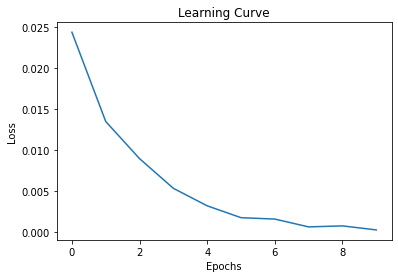

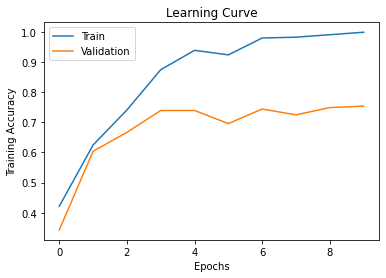

Final Training Accuracy: 0.9986357435197817
Final Validation Accuracy: 0.7536231884057971
Final Test Accuracy 0.6860986547085202


In [ ]:
model = CNN_BATCH(3)

train(model, 
      train_data, 
      valid_data, 
      batch_size=64, 
      num_epochs=10, 
      checkpoint_name="cnnBatch")

print("Final Test Accuracy", get_accuracy(model, test_data))

### Part (d) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (c).
In this section, briefly explain the hyperparamter choices that you tried, 
and how they impacted your training.

# Answer: Question 4 Part (d)

<table>
<tr>
<th>Trials</th>
<th>Batch Size</th>
<th>Epochs</th>
<th>Training Accuracy</th>
<th>Validation Accuracy</th>
<th>Testing Accuracy</th>
</tr>
<tr>
<th>1</th>
<th>32</th>
<th>7</th>
<th>98</th>
<th>68</th>
<th>65</th>
</tr>
<tr>
<th>2</th>
<th>128</th>
<th>10</th>
<th>96</th>
<th>71</th>
<th>66</th>
</tr>

<tr>
<th>3</th>
<th>256</th>
<th>20</th>
<th>72</th>
<th>58</th>
<th>60</th>
</tr>
<tr>
<th>4</th>
<th>64</th>
<th>10</th>
<th>100</th>
<th>76</th>
<th>70</th>
</tr>
<tr>
<th>5</th>
<th>64</th>
<th>20</th>
<th>100</th>
<th>78</th>
<th>70</th>
</tr>
<tr>
<th>6</th>
<th>64</th>
<th>40</th>
<th>100</th>
<th>78</th>
<th>69</th>
</tr>
<tr>
<th>7</th>
<th>32</th>
<th>20</th>
<th>100</th>
<th>78</th>
<th>70</th>
</tr>
</table>

We tried the above batch size and epochs and we observed that with larger batch sizes (128, 256) the model was tending to get very poor training and testing accuracy. Thus we tried smaller batch sizes with higher epochs but we observed the model seems to be overfitting as it was achieving 100% training accuracy while getting 70% testing accuracy. Hence the optimal batch size was 64 with 10 epochs. 

### Part (e) -- 1 pts

Out of all the models (i.e. parts (a) vs (c), and the various hyperparameter choices)
that you tried, which model is the "best"?
If you were to select a single set of weight values (checkpoints)
to deploy and use in a real application, which would you choose?

# Answer: Question 4 Part (e)

The model in part a was achieving slightly better results than the model in part c. Hence I would use the weight values in part a, with batch size 64 with 20 epochs.

## Question 5. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a
similar task to the one you need to solve. This method of using a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**. In this question, we will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, the AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this assignment.

### Part (a)

Here is the code to load the AlexNet network, with pretrained weights.
When you first run the code, PyTorch will download the pretrained weights
from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The `alexnet` model is split up into two components: `alexnet.features` and 
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how you can compute the AlexNet
features for some images (your actual code might be different):

In [ ]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

Note that the `.detach()` at the end will be necessary in your code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
gradients. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

Compute the AlexNet features for each of your training, validation, and test data.
In other words, create three new arrays called `train_data_features`, `valid_data_features`
and `test_data_features`. Each of these arrays should contain tuples of the form 
`(alexnet_features, label)`

In [ ]:
# Modify this code

train_data_features = []
for img, y in train_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    train_data_features.append((features, y))

valid_data_features = []
for img, y in valid_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    valid_data_features.append((features, y))

test_data_features = []
for img, y in test_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    test_data_features.append((features, y))

### Part (b)


Create a multi-layer preceptron that
takes **as input** these AlexNet features,
and makes a prediction. Your model should be a subclass of `nn.Module`.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(256 * 6 * 6, 350)
        self.layer2 = nn.Linear(350, 10)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        return x

### Part (c)

Train the `MLP()` model for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.

This model should train *much* faster since it has very few parameters.
However, this model should attain much better accuracy much faster!

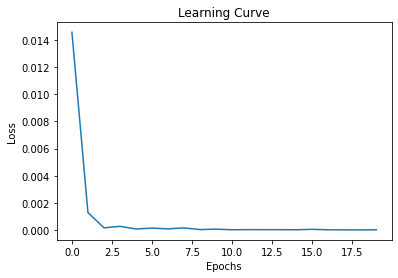

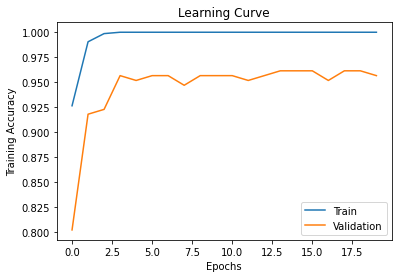

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9565217391304348


0.8295964125560538

In [ ]:
mlp = MLP()
train(mlp, 
      train_data_features, 
      valid_data_features, 
      batch_size=32, 
      num_epochs=20, 
      checkpoint_name="mlp")
get_accuracy(mlp, test_data_features)

## Question 6. Test Accuracy

### Part (a) -- 5 pts

Report the test accuracies of your **single best** model for the test set, including
any model that you trained (including in Q5).

# Answer: Question 6 Part (a)

<table>
<tr>
<th>Trials</th>
<th>Batch Size</th>
<th>Epochs</th>
<th>Training Accuracy</th>
<th>Validation Accuracy</th>
<th>Testing Accuracy</th>
</tr>
<tr>
<th>1</th>
<th>32</th>
<th>7</th>
<th>100</th>
<th>97</th>
<th>82</th>
</tr>
<tr>
<th>2</th>
<th>128</th>
<th>10</th>
<th>100</th>
<th>95</th>
<th>81</th>
</tr>

<tr>
<th>3</th>
<th>256</th>
<th>20</th>
<th>100</th>
<th>94</th>
<th>81</th>
</tr>
<tr>
<th>4</th>
<th>64</th>
<th>10</th>
<th>100</th>
<th>96</th>
<th>83</th>
</tr>
<tr>
<th>5</th>
<th>64</th>
<th>20</th>
<th>100</th>
<th>96</th>
<th>82</th>
</tr>
<tr>
<th>6</th>
<th>64</th>
<th>40</th>
<th>100</th>
<th>98</th>
<th>84</th>
</tr>
<tr>
<th>7</th>
<th>32</th>
<th>20</th>
<th>100</th>
<th>95</th>
<th>83</th>
</tr>
</table>

The test accuracy of our best model is the MLP model with 84% accuracy with batch size of 64, and 40 epochs.

### Part (b) -- 1 pts

Display one image that your model correctly classified.

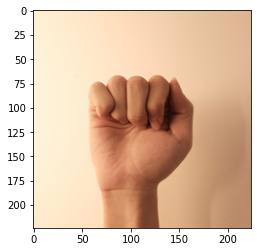

MLP Model Classified As 0
Correct Label is 0


In [ ]:
index = 0
for img_feature, y in test_data_features:
    model_guess = int(mlp(img_feature).max(1, keepdim=True)[1][0][0])
    if model_guess == y:
        img = test_data[index][0]
        plt.imshow(img.permute(1, 2, 0))
        plt.show()
        print("MLP Model Classified As", model_guess)
        print("Correct Label is", y)
        break
    index += 1

### Part (b) -- 1 pts

Display one image that your model incorrectly classified. (If your test performance was 100%, please just say so.)

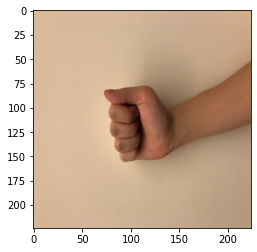

MLP Model Classified As 6
Correct Label is 0


In [ ]:
index = 0
for img_feature, y in test_data_features:
    model_guess = int(mlp(img_feature).max(1, keepdim=True)[1][0][0])
    if model_guess != y:
        img = test_data[index][0]
        plt.imshow(img.permute(1, 2, 0))
        plt.show()
        print("MLP Model Classified As", model_guess)
        print("Correct Label is", y)
        break
    index += 1

## Question 6. Adversarial Examples -- 2 pts

In this question you will take the trained model you selected in Q4 (e),
and you will freeze its weights (i.e. do not optimize it further). Let's call this model $f()$.
Select an image (let's call it $x$) from the test set, where $f(x)$ outputs the correct label $y$.
Then, compute an adversarial noise image (let's call it $n$) that you will add to $x$ in order to change
the original label to an incorrect one, i.e. $f(x + n) \neq f(x)$, while keeping the value of the noise
pixels small, i.e. $|n_{i,j}| < \epsilon$. You have control over $\epsilon$, but keep in mind that the
noise should be imperceptible to the human eye when not zooming into the image.

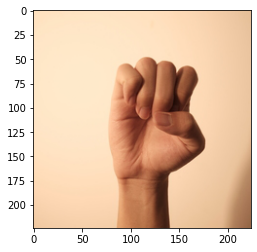

Model Classified As 4
Correct Label is 4


In [ ]:
#
# Make sure your code, original image x, and the corrupted image x + n are shown to the TA
# Show the output f(x) = y and the output f(x + n) is different than y.
#

model = CNN(3)
model.load_state_dict(torch.load('/content/gdrive/My Drive/A2/cnn/ckpt-19.pk'))
model.eval()

index = 0
for img_feature, y in test_data:
    if index > 100:
        model_guess = int(model(img_feature).max(1, keepdim=True)[1][0][0])
        if model_guess == y:
            correct_img = test_data[index][0]
            correct_label = y

            plt.imshow(correct_img.permute(1, 2, 0))
            plt.show()
            print("Model Classified As", model_guess)
            print("Correct Label is", correct_label)

            break

    index += 1

In [ ]:
def attack(image, model, target, epsilon=1e-4):
    """
    Function taken from: 
    https://medium.com/mlearning-ai/adversarial-attacks-introduction-and-example-3224ccffc720
    """
    input = image
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    output = input - epsilon * input.grad.sign()
    return torch.clamp(output.detach(),0,1)

Altered Image Prediction:  5


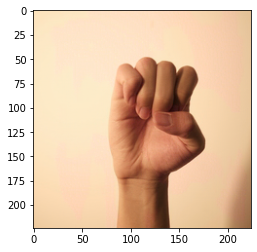

In [ ]:
altered_img = attack(correct_img, model, torch.tensor([5]))
for _ in range(100):
    altered_img = attack(altered_img, model, torch.tensor([5]))

print("Altered Image Prediction: ", int(model(altered_img).max(1, keepdim=True)[1][0][0]))
plt.imshow(altered_img.permute(1, 2, 0))
plt.show()

## Question 7. Work Allocation -- 1 pts

This question is to make sure that if you are working with a partner, that
you and your partner contributed equally to the assignment.

Please have each team member write down the times that you worked on the
assignment, and your contribution to the assignment.

We both worked together on all the questions througout this assignment. 